<a href="https://colab.research.google.com/github/Lawliet19189/Dirichlet/blob/main/invert_STFT_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root_path = "drive/MyDrive/Dirichlet/"

Mounted at /content/drive


# Let's install & Import all the amazing Libraries


---



In [ ]:
!pip install torch torchvision torchaudio wandb scipy tqdm matplotlib

In [ ]:
# audio processing
import torchaudio
import scipy
import scipy.signal
from scipy.fft import fft
from scipy.signal import spectrogram

# For Plots
import matplotlib.pyplot as plt

# For progress
from tqdm import tqdm

# For logging
import wandb

# For Deep learning
import torch
import torch.nn as nn
import numpy as np

# For re-producability
torch.manual_seed(0)
import random
random.seed(0)
np.random.seed(0)

# python libs
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

root_path = ""

In [ ]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: srivardhamanan (use `wandb login --relogin` to force relogin)


True

# In this Project, we would be using LibriSpeech ASR corpus. 


---

## The corpus contains 1000 hours of 16kHz read English Speech.

### Let's Download the Dataset using torchaudio datasets.

##### **This might take aproximately 5 mins.*



In [ ]:

Path("Dataset/train").mkdir(parents=True, exist_ok=True)
Path("Dataset/dev").mkdir(parents=True, exist_ok=True)

train_samples = torchaudio.datasets.LIBRISPEECH(root_path + "Dataset/train", url="train-clean-100", download=True)
train_loader = torch.utils.data.DataLoader(train_samples,
                                          batch_size=1,
                                          shuffle=True)


dev_samples = torchaudio.datasets.LIBRISPEECH(root_path + "Dataset/dev", url="dev-clean", download=True)
dev_loader = torch.utils.data.DataLoader(dev_samples,
                                          batch_size=1,
                                          shuffle=False)

print("Number of Training Samples: ", len(train_samples))
print("Number of Development Samples: ", len(dev_samples))

Number of Training Samples:  28539
Number of Development Samples:  2703


## Let's define a simple class which we can use to compute Short-time Fourier Transform

In [ ]:
class compute_stft(object):
    def __init__(self, nfft, overlap, onesided):
        self.nfft = nfft
        self.overlap = overlap
        self.onesided = onesided
        
    def __call__(self, sample):
        self.sampling_rate = sample[1].tolist()[0]
        signal_x = sample[0][0][0]
        text = sample[2]
        
        if isinstance(signal_x, torch.Tensor):
            x = signal_x.detach().cpu().numpy()
        f, t1, Zxx = scipy.signal.stft(x, nperseg=self.nfft, noverlap=overlap, nfft=self.nfft, padded=True, fs=16000, return_onesided=self.onesided, window=window)
        
        X = Zxx.reshape(1, 1, Zxx.shape[0], -1)
        X = np.stack((X.real,X.imag),axis=1)
        X = torch.Tensor(X)
        X = X.to(device)
        signal_x = signal_x.to(device)
        return (signal_x, X)

In [ ]:
# STFT configurations
nfft = 80
overlap = None  # uses nfft//4
onesided = True
window = "hamming"  # Hamming window is preferred over hann when our goal is recreate the original signal
sampling_rate = 16000 # As per the Dataset

# Let's initialize the class

stft_fnc = compute_stft(nfft, overlap, onesided)

## Pytorch implementation of complex convolutional neural network : 

#### *Reference: https://arxiv.org/pdf/1705.09792.pdf*

In [ ]:

class ComplexConv(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride=80//4, padding=0, dilation=1, groups=1, bias=True):
        super(ComplexConv,self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.padding = padding

        self.conv_re = nn.Conv2d(in_channel, out_channel, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias).to(self.device)
        self.conv_im = nn.Conv2d(in_channel, out_channel, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias).to(self.device)
        
    def forward(self, x): 
        """
        Args
          x : input of shape [batch, 2, in_channel, axis1, axis2]
        Output
          out: CNN output of shape [batch, 2, out_channel, *, *]
        """
      
        real = self.conv_re(x[:,0]) - self.conv_im(x[:,1])
        imaginary = self.conv_re(x[:,1]) + self.conv_im(x[:,0])
        out = torch.stack((real,imaginary),dim=1)
        out = torch.swapaxes(out.squeeze()[0], 0, 1).flatten()
        return out

## Helper functions

In [ ]:
def check_validation(model, data, epoch=0, logging="wandb", comparison=None):
    if logging=="wandb":
        columns=["id", "trueSignal", "trueTDR", "trueFDR", "trueSpectogram" ,"craftedISTFT", "craftedTDR", "craftedFDR", "craftedSpectogram","learnedISTFT", "learnedTDR", "learnedFDR", "learnedSpectogram"]

        val_table = wandb.Table(columns=columns)

    model.eval()
    val_loss = []
    for itr, sample in enumerate(data):
        signal_x, X = stft_fnc(sample)
        out = model(X)
        if len(out)!=len(signal_x):
            continue
        
        loss = loss_fnc(out, signal_x)
        val_loss.append(loss.detach().cpu())
        
        # wandb tables visualization
        if itr<10 and epoch!=None:
            # original signal
            signal_x = signal_x.detach().cpu().numpy()
            plot_t_and_f_reps(signal_x, fs=16000, filename= root_path + "images/org_", show_plot=False)
            save_spectogram(signal_x, filename= root_path + "images/org_", show_plot=False)
            
            # through istft
            f, t1, Zxx = scipy.signal.stft(signal_x, nperseg=80, noverlap=None, padded=True, fs=16000, return_onesided=onesided, window=window)
            t2, x_hat = scipy.signal.istft(Zxx, nperseg=80, noverlap=None, input_onesided=onesided, window=window)
            plot_t_and_f_reps(x_hat, fs=16000, filename= root_path + "images/istft_", show_plot=False)
            save_spectogram(x_hat, filename= root_path + "images/istft_", show_plot=False)
            
            # learned istft
            out = out.detach().cpu().numpy()
            plot_t_and_f_reps(out, fs=16000, filename= root_path + "images/learned_", show_plot=False)
            save_spectogram(out, filename= root_path + "images/learned_", show_plot=False)
            
            
            sr=16000
            val_table.add_data(itr, wandb.Audio(signal_x, sample_rate=sr), \
                             wandb.Image(root_path + "images/org_tdr.jpg"), wandb.Image(root_path + "images/org_fdr.jpg"), \
                             wandb.Image(root_path + "images/org_spectogram.jpg"), wandb.Audio(x_hat, sample_rate=sr), \
                             wandb.Image(root_path + "images/istft_tdr.jpg"), wandb.Image(root_path + "images/istft_fdr.jpg"), \
                             wandb.Image(root_path + "images/istft_spectogram.jpg"), wandb.Audio(out, sample_rate=sr), \
                             wandb.Image(root_path + "images/learned_tdr.jpg"), wandb.Image(root_path + "images/learned_fdr.jpg"), \
                             wandb.Image(root_path + "images/learned_spectogram.jpg"))
        
    loss_avg = np.average(val_loss)
    
    
    if epoch!=None and logging=="wandb":
        wandb.log({"epoch_"+str(epoch): val_table})
        wandb.log({"Epoch validation loss": np.average(loss_avg)})
    elif logging=="wandb":
        wandb.log({"validation loss": np.average(loss_avg)})
    return loss_avg

def save_spectogram(signal_x, filename="images/org_", show_plot=True):
    f_bins, t_bins, Sxx = spectrogram(signal_x, fs=16000,
                                     window=window, nperseg=80,
                                     noverlap=None, detrend=False,
                                     scaling='spectrum', return_onesided=onesided)
    plt.pcolormesh(t_bins, f_bins, 20*np.log10(Sxx+1e-100), cmap='magma', shading='auto')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.ylim([0, 6e3])
    if show_plot:
        plt.show()
    plt.savefig(filename + "spectogram.jpg")
    plt.close()

def plot_t_and_f_reps(signal, fs, lw=0.1, fmax=6e3, filename="images/org_", show_plot=True):
    N = len(signal)
    delta_t = 1 / fs
    times = np.arange(0, N) / fs
    signalf = fft(signal)
    freqs = np.linspace(0.0, 1.0/(2.0*delta_t), N//2)
    
    fig, axs = plt.subplots(1,1, figsize=(10,5))
    axs.plot(times, signal, linewidth=lw)
    axs.set_xlabel('Time (s)')
    axs.set_ylabel('Amplitude')
    axs.set_title('Time Domain Representation')
    fig.savefig(filename + "tdr.jpg")
    
    fig, axs = plt.subplots(1,1, figsize=(10,5))
    axs.plot(freqs, 2.0/N * np.abs(signalf[0:N//2]), linewidth=0.4)
    axs.set_xlabel('Frequency (Hz)')
    axs.set_ylabel('Amplitude')
    axs.set_title('Frequency Domain Representation')
    axs.set_xlim([0, fmax])
    
    if show_plot:
        plt.show()
    fig.savefig(filename + "fdr.jpg")
    plt.close()
    

## Model Training code

In [ ]:
def train(model, opt, train_loader, dev_loader, config):
    err_sample = 0
    itr = 1
    for epoch in range(1, config['num_epochs']+1):
        #print(f'Starting epoch {epoch}...')
        with torch.enable_grad(), \
                    tqdm(total=len(train_loader.dataset)) as progress_bar:

            #ema.assign(model)
            check_validation(model, dev_loader, epoch=epoch)
            #ema.resume(model)

            losses = []
            continous_loss = []
            for sample in train_loader:

                # short-time fourier transform of the sample signal
                signal_x, X = stft_fnc(sample)

                # NN model forward pass
                out = model(X)
                
                # Few signals are error prone
                if len(out)!=len(signal_x):
                    err_sample += 1
                    continue
                    
                itr += 1
                
                # Get MSE loss
                loss = loss_fnc(out, signal_x)

                #opt.zero_grad()
                loss = loss #/ config["batch_size"]
                loss.backward()
                #opt.step()
                #losses.append(loss.item())
                #continous_loss.append(loss.item())

                ## For Gradient Accumulation
                if ((itr) % config['batch_size'] == 0) or (itr % len(train_loader) == 0):
                    losses.append(loss.item())
                    continous_loss.append(loss.item())
                    opt.step()
                    opt.zero_grad()
                
                # Gradient clipping to prevent exploding
                #nn.utils.clip_grad_norm_(model.parameters(), 5.0)

                #ema(model, itr*epoch // args['batch_size'])
                
                # update progress bar
                progress_bar.update(1)
                progress_bar.set_postfix(epoch=epoch,
                                            MSE=loss.item())
                
                if not itr%config['print_every']:
                    wandb.log({"Training loss": np.average(continous_loss)})
                    continous_loss = []

                if not itr%config['eval_steps']:
                    #print(f'Evaluating at step {itr}...')
                    #ema.assign(model)
                    check_validation(model, dev_loader, epoch=None)
                    model.train()
                    #ema.resume(model)

        wandb.log({"Training Epoch Loss": np.average(losses)})
        torch.save(model.state_dict(), root_path + "models/v1/checkpoint-"+str(epoch)+".pt")
        if opt.param_groups[0]['lr'] * 0.1 <= config['max_lr']:
            opt.param_groups[0]['lr'] = opt.param_groups[0]['lr'] * 0.1
    wandb.finish()
    torch.cuda.empty_cache()

## Model Configs


In [ ]:
config={
    "print_every": 64,
    "max_itr": -1,
    "lr": 2e-1,
    "num_epochs":10,
    "batch_size":64,
    "dataset": "LibriSpeech",
    "optimizer": "AdamW",
    "eval_steps": 64*40,
    "max_lr": 5e-5
}

## Let's Finally Train the Model

In [ ]:
# model 
model = ComplexConv(in_channel=1, out_channel=nfft//2, kernel_size=(nfft//2+1 if onesided else nfft, 2 if overlap==None else 1), stride=1).to(device)

# Initialize model weights with Xavier uniform
def init_weights(m):
    if type(m) in [nn.Conv2d, nn.Conv1d]:
        #torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)
model.apply(init_weights)
model.train()
#ema = EMA(model, 0.999)

loss_fnc = nn.MSELoss(size_average=None, reduce=None, reduction='mean')

# initialize AdamW optimizer
opt = torch.optim.AdamW(model.parameters(), lr=config['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0, amsgrad=True)

# let's close existing wandb runs
if wandb.run is not None:
    wandb.finish()

# Initialize wandb
wandb.init(
      entity="srivardhamanan",
      project="learnable-istft", 
      config=config)

wandb.watch(model, log_freq=100, log='all')


_runtime,76
_timestamp,1625041606
_step,1
Epoch validation loss,0.00448


_runtime,▁█
_timestamp,▁█
_step,▁█
Epoch validation loss,▁


wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
%%wandb

train(model, opt, train_loader, dev_loader, config)

 98%|█████████▊| 28085/28539 [14:47<00:14, 31.64it/s, MSE=8.96e-17, epoch=10]   


_runtime,6212
_timestamp,1625047938
_step,4526
Epoch validation loss,0.0
Training loss,0.0
validation loss,0.0
Training Epoch Loss,0.0


_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Epoch validation loss,█▁▁▁▁▁▁▁▁▁
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Epoch Loss,█▁▁▁▁▁▁▁▁▁


# let's run some examples from validation corpus

In [ ]:
# audio processing
import torchaudio
import scipy
import scipy.signal
from scipy.fft import fft
from scipy.signal import spectrogram

# For Plots
import matplotlib.pyplot as plt

# For progress
from tqdm import tqdm

# For logging
import wandb

# For Deep learning
import torch
import torch.nn as nn
import numpy as np

# For re-producability
torch.manual_seed(0)
import random
random.seed(0)
np.random.seed(0)

# python libs
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

root_path = ""

In [ ]:
Path("Dataset/test").mkdir(parents=True, exist_ok=True)

test_samples = torchaudio.datasets.LIBRISPEECH(root_path + "Dataset/test", url="test-clean", download=True)
test_loader = torch.utils.data.DataLoader(test_samples,
                                          batch_size=1,
                                          shuffle=False)

print("Number of Testing Samples: ", len(test_samples))

Number of Testing Samples:  2620


In [ ]:

class ComplexConv(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride=80//4, padding=0, dilation=1, groups=1, bias=True):
        super(ComplexConv,self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.padding = padding

        self.conv_re = nn.Conv2d(in_channel, out_channel, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias).to(self.device)
        self.conv_im = nn.Conv2d(in_channel, out_channel, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias).to(self.device)
        
    def forward(self, x): 
        """
        Args
          x : input of shape [batch, 2, in_channel, axis1, axis2]
        Output
          out: CNN output of shape [batch, 2, out_channel, *, *]
        """
      
        real = self.conv_re(x[:,0]) - self.conv_im(x[:,1])
        imaginary = self.conv_re(x[:,1]) + self.conv_im(x[:,0])
        out = torch.stack((real,imaginary),dim=1)
        out = torch.swapaxes(out.squeeze()[0], 0, 1).flatten()
        return out

class compute_stft(object):
    def __init__(self, nfft, overlap, onesided):
        self.nfft = nfft
        self.overlap = overlap
        self.onesided = onesided
        
    def __call__(self, sample):
        self.sampling_rate = sample[1].tolist()[0]
        signal_x = sample[0][0][0]
        text = sample[2]
        
        if isinstance(signal_x, torch.Tensor):
            x = signal_x.detach().cpu().numpy()
        f, t1, Zxx = scipy.signal.stft(x, nperseg=self.nfft, noverlap=overlap, nfft=self.nfft, padded=True, fs=16000, return_onesided=self.onesided, window=window)
        
        X = Zxx.reshape(1, 1, Zxx.shape[0], -1)
        X = np.stack((X.real,X.imag),axis=1)
        X = torch.Tensor(X)
        X = X.to(device)
        signal_x = signal_x.to(device)
        return (signal_x, X)

In [ ]:
loss_fnc = nn.MSELoss(size_average=None, reduce=None, reduction='mean')

# STFT configurations
nfft = 80
overlap = None  # uses nfft//4
onesided = True
window = "hamming"  # Hamming window is preferred over hann when our goal is recreate the original signal
sampling_rate = 16000 # As per the Dataset

# Let's initialize the class


model = ComplexConv(in_channel=1, out_channel=nfft//2, kernel_size=(nfft//2+1 if onesided else nfft, 2 if overlap==None else 1), stride=1).to('cuda')

model.load_state_dict(torch.load("models/v1/checkpoint-3.pt"))
model.eval()


stft_fnc = compute_stft(nfft, overlap, onesided)
check_validation(model, test_loader, epoch=None, logging=None)

1.6175321e-16

In [ ]:
import sounddevice as sd
from scipy.io.wavfile import write

fs = 16000
seconds = 5

recording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()
write(root_path + 'recordings/output.wav', fs, recording)

In [ ]:
recording.shape

(80000, 1)

In [ ]:
import IPython.display as ipd
ipd.Audio(recording.flatten(), rate=fs)

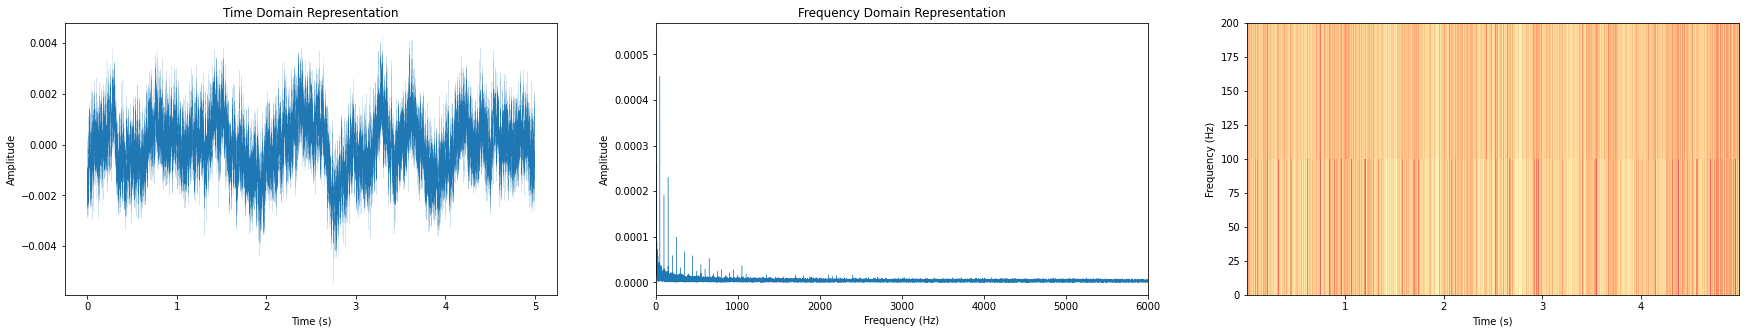

In [ ]:
from scipy.fft import fft
import matplotlib.pyplot as plt
from scipy.signal import spectrogram


def signal_plots(signal, fs, lw=0.1, fmax=6e3):
    N = len(signal)
    delta_t = 1 / fs
    times = np.arange(0, N) / fs
    signalf = fft(signal)
    freqs = np.linspace(0.0, 1.0/(2.0*delta_t), N//2)
    
    fig, axs = plt.subplots(1,3, figsize=(30,5))
    axs[0].plot(times, signal, linewidth=lw)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_title('Time Domain Representation')
    
    axs[1].plot(freqs, 2.0/N * np.abs(signalf[0:N//2]), linewidth=0.4)
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Amplitude')
    axs[1].set_title('Frequency Domain Representation')
    axs[1].set_xlim([0, fmax])
    
    f_bins, t_bins, Sxx = spectrogram(signal, fs=fs,
                             window='hanning', nperseg=80,
                             noverlap=None, detrend=False,
                             scaling='spectrum')
    
    axs[2].pcolormesh(t_bins, f_bins, 20*np.log10(Sxx+1e-100), cmap='magma', shading="auto")
    axs[2].set_ylabel('Frequency (Hz)')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylim([0, 2e2])
    plt.show()


# original recording
#plot_t_and_f_reps(recording.flatten(), fs, lw=0.1, fmax=6e3)
signal_plots(recording.flatten(), fs, lw=0.1, fmax=6e3)

In [ ]:
_, _, Zxx = scipy.signal.stft(recording.flatten(), nperseg=nfft, noverlap=overlap, nfft=nfft, padded=True, fs=16000, return_onesided=onesided, window=window)
X = Zxx.reshape(1, 1, Zxx.shape[0], -1)
X = np.stack((X.real,X.imag),axis=1)
X = torch.Tensor(X)
X = X.to(device)
dout = model(X)

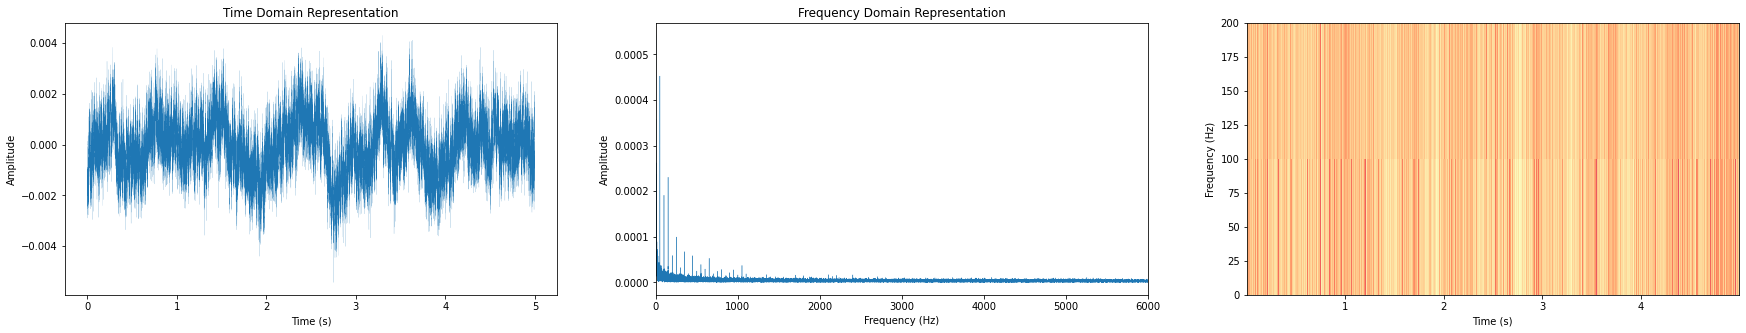

In [ ]:
# recreated signal using our model
signal_plots(dout.detach().cpu().numpy(), fs, lw=0.1, fmax=6e3)